In [1]:
from mip import *
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

# Parameter

In [2]:
N = 2
T = 10
set_N = set(range(N))
set_T = set(range(T))
d_s = [5000/(1+50*np.exp(-0.1*(t+1))) for t in set_T]
d_m = [279/(1+2.2*np.exp(-0.33*(t+1))) for t in set_T]
d_f = [258/(1+3.4*np.exp(-0.9*(t+1))) for t in set_T]
h = [[3,3,3,3,3,3,3,3,3,3],[2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5]]
mu = [[5,5,5,5,5,5,5,5,5,5],[5,5,5,5,5,5,5,5,5,5]]
r = 0
s = [50,50]
Pmax = [10,10]
delta = [5,5]
tau = [1, 1]
g = [[Pmax[i] - delta[i]*np.exp(-(t+1)/tau[i]) for t in set_T] for i in set_N]
alpha = 2
M = 1000000

C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


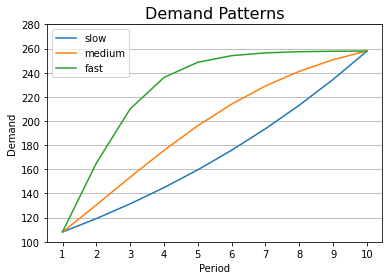

In [3]:
sns.lineplot(list(set_T),d_s,label='slow')
sns.lineplot(list(set_T),d_m,label='medium')
sns.lineplot(list(set_T),d_f,label='fast')




plt.xlabel('Period')
plt.xticks(range(0,10), range(1,11))
plt.ylabel('Demand')
plt.yticks(range(100,300,20), range(100,300,20))
plt.title('Demand Patterns', fontsize =16)
plt.legend()
plt.grid(axis='y')

plt.show()

# Model_S

In [4]:
m_s = Model()

# Variables 

In [5]:
l = [[m_s.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_s.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
#w = [[[m.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in T if t>=t_p]  for t_p in T] for i in N]
w = [[[m_s.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_s.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_s.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_s.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_s.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]




# Objective

In [6]:
m_s.objective = minimize(xsum(s[i]*y[i][t] + h[i][t]*l[i][t] + mu[i][t]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

# Constraints

In [7]:
d = d_s

In [8]:
#2
for t in set_T:
        m_s += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

#3
for (i,t) in product(set_N-{0}, set_T):
        m_s += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

#4
for (i,t) in product(set_N,set_T):
        m_s += p[i][t] == xsum(w[i][t_p][t]*g[i][t-t_p] for t_p in range(t+1) )

#5
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_s += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

#6
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_s += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M
    
#7
for (i,t) in product(set_N,set_T):
    #if y_a+y_w == 2:
        #alpha = 2
    #else: 
        #alpha = 1
    m_s += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]
    
#8
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_s += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

#9
for (i,t) in product(set_N,set_T):
    m_s += w[i][t][t] <= y_a[i][t]*M
    
#10
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_s += z[i][t_p][t] <= y_w[i][t]*M

#11
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_s += z[i][t_p][t] >= 0


#12
for (i,t) in product (set_N,set_T):
    m_s += l[i][t] >= 0
    
#13
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_s += w[i][t_p][t] >= 0 
        

In [9]:
solution_s = m_s.optimize()

In [10]:
if solution_s == OptimizationStatus.OPTIMAL:
    print('Optimal Solution: {}'.format(m_s.objective_value))

Optimal Solution: 2296.361829960932


In [11]:
inv_s = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [12]:
for i in set_N:
    for t in set_T:
        inv_s[t+1][i+1] = l[i][t].x

In [13]:
inv_s

,1,2,3,4,5,6,7,8,9,10
1,2.528023,9.721504,10.505348,0.0,0.0,4.989936,0.0,0.0,6.557153,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
prod_s = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [15]:
for i in set_N:
    for t in set_T:
        prod_s[t+1][i+1] = p[i][t].x

In [16]:
prod_s

,1,2,3,4,5,6,7,8,9,10
1,110.655136,126.421254,132.221285,134.354997,159.609108,180.79506,188.588935,213.070165,240.985453,251.254913
2,110.655136,126.421254,132.221285,134.354997,159.609108,180.79506,188.588935,213.070165,240.985453,251.254913


In [17]:
demand_s = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Demand'])
for t in set_T:
    demand_s[t+1]= d_s[t]
demand_s

,1,2,3,4,5,6,7,8,9,10
Demand,108.127113,119.227773,131.437441,144.860345,159.609108,175.805124,193.578871,213.070165,234.4283,257.812066


In [18]:
worker_s_list=[]
for i in (set_N):
    for t_p in range(t+1):
        for t in (set_T):
            if t>=t_p:
                if w[i][t_p][t].x > 0.01:
                    worker_s_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_s_list.append(w[i][t_p][t].x)
                elif w[i][t_p][t].x == 0 and i==0:
                    i+=1
                    worker_s_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_s_list.append(w[i][t_p][t].x)

In [19]:
worker_s = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,5,8])

In [20]:
worker_s_list

['1,1,1',
 13.559676766985074,
 '1,1,2',
 13.559676766985074,
 '1,1,3',
 13.559676766985074,
 '1,1,4',
 13.559676766985074,
 '1,1,5',
 1.1118294337860024,
 '1,1,6',
 1.1118294337860024,
 '1,1,7',
 1.1118294337860024,
 '2,1,8',
 1.1118294337859946,
 '2,1,9',
 1.1118294337859946,
 '2,1,10',
 1.1118294337859946,
 '2,5,5',
 18.200649520212345,
 '2,5,6',
 18.200649520212345,
 '2,5,7',
 18.200649520212345,
 '2,5,8',
 0.6353775538475285,
 '2,5,9',
 0.6353775538475285,
 '2,5,10',
 0.6353775538475285,
 '2,8,8',
 23.975942960359934,
 '2,8,9',
 23.975942960359934,
 '2,8,10',
 23.975942960359934,
 '2,1,1',
 13.559676766985076,
 '2,1,2',
 13.559676766985078,
 '2,1,3',
 13.559676766985078,
 '2,1,4',
 13.559676766985078,
 '2,1,5',
 1.1118294337859946,
 '2,1,6',
 1.1118294337859946,
 '2,1,7',
 1.1118294337859946,
 '2,1,8',
 1.1118294337859946,
 '2,1,9',
 1.1118294337859946,
 '2,1,10',
 1.1118294337859946,
 '2,5,5',
 18.200649520212345,
 '2,5,6',
 18.200649520212345,
 '2,5,7',
 18.200649520212345,
 '2,

In [21]:
worker_s.iloc[0] = worker_s_list[0:10]
worker_s.iloc[1][4:] = worker_s_list[10:16]
worker_s.iloc[2][7:] = worker_s_list[16:19]

In [22]:
worker_s

,1,2,3,4,5,6,7,8,9,10
1,"1,1,1",13.559677,"1,1,2",13.559677,"1,1,3",13.559677,"1,1,4",13.559677,"1,1,5",1.111829
5,NaN,NaN,NaN,NaN,"1,1,6",1.111829,"1,1,7",1.111829,"2,1,8",1.111829
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,1,9",1.111829,"2,1,10"


In [23]:
table_s = pd.concat([worker_s,demand_s,inv_s])

In [24]:
table_s['Feature'] = ['# of workers committed in period 1','# of workers committed in period 4','# of workers committed in period 7','Demand','inv 1','inv 2']

In [25]:
table_s.reset_index()
table_s.set_index('Feature', inplace=True)

In [70]:
table_s

,1,2,3,4,5,6,7,8,9,10
Feature,,,,,,,,,,
# of workers committed in period 1,"1,1,1",13.559677,"1,1,2",13.559677,"1,1,3",13.559677,"1,1,4",13.559677,"1,1,5",1.111829
# of workers committed in period 4,NaN,NaN,NaN,NaN,"1,1,6",1.111829,"1,1,7",1.111829,"2,1,8",1.111829
# of workers committed in period 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"2,1,9",1.111829,"2,1,10"
Demand,108.127113,119.227773,131.437441,144.860345,159.609108,175.805124,193.578871,213.070165,234.4283,257.812066
inv 1,2.528023,9.721504,10.505348,0.0,0.0,4.989936,0.0,0.0,6.557153,0.0
inv 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model_M

In [26]:
d=d_m

In [27]:
m_m = Model()

# Variables

In [28]:
l = [[m_m.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_m.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
#w = [[[m.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in T if t>=t_p]  for t_p in T] for i in N]
w = [[[m_m.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_m.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_m.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_m.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_m.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]


# Objective

In [29]:
m_m.objective = minimize(xsum(s[i]*y[i][t] + h[i][t]*l[i][t] + mu[i][t]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

# Constraints

In [30]:
#2
for t in set_T:
        m_m += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

#3
for (i,t) in product(set_N-{0}, set_T):
        m_m += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

#4
for (i,t) in product(set_N,set_T):
        m_m += p[i][t] == xsum(w[i][t_p][t]*g[i][t-t_p] for t_p in range(t+1) )

#5
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_m += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

#6
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_m += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M
    
#7
for (i,t) in product(set_N,set_T):
    #if y_a+y_w == 2:
        #alpha = 2
    #else: 
        #alpha = 1
    m_m += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]
    
#8
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_m += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

#9
for (i,t) in product(set_N,set_T):
    m_m += w[i][t][t] <= y_a[i][t]*M
    
#10
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_m += z[i][t_p][t] <= y_w[i][t]*M

#11
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_m += z[i][t_p][t] >= 0


#12
for (i,t) in product (set_N,set_T):
    m_m += l[i][t] >= 0
    
#13
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_m += w[i][t_p][t] >= 0 

In [31]:
solution_m = m_m.optimize()

if solution_m == OptimizationStatus.OPTIMAL:
    print('Optimal Solution: {}'.format(m_m.objective_value))

Optimal Solution: 2502.522952883103


In [32]:
inv_m = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [33]:
for i in set_N:
    for t in set_T:
        inv_m[t+1][i+1] = l[i][t].x

In [34]:
inv_m

,1,2,3,4,5,6,7,8,9,10
1,9.426504,13.112814,0.0,0.0,4.374595,0.0,0.0,4.10676,4.631672,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
prod_m = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [36]:
for i in set_N:
    for t in set_T:
        prod_m[t+1][i+1] = p[i][t].x

In [37]:
prod_m

,1,2,3,4,5,6,7,8,9,10
1,117.497669,134.238709,140.397394,175.726151,200.506811,209.623107,228.993583,245.248727,251.228661,253.428555
2,117.497669,134.238709,140.397394,175.726151,200.506811,209.623107,228.993583,245.248727,251.228661,253.428555


In [38]:
demand_m = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Demand'])
for t in set_T:
    demand_m[t+1]= d_f[t]
demand_m

,1,2,3,4,5,6,7,8,9,10
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179


In [39]:
worker_m_list=[]
for i in (set_N):
    for t_p in range(t+1):
        for t in (set_T):
            if t>=t_p:
                if w[i][t_p][t].x > 0.01:
                   # worker_m_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_m_list.append(w[i][t_p][t].x)
                elif w[i][t_p][t].x == 0 and i==0:
                    i+=1
                    #worker_m_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_m_list.append(w[i][t_p][t].x)




In [40]:
worker_m_list

[14.398160479177626,
 14.398160479177626,
 14.398160479177626,
 0.18965107972809725,
 0.18965107972809725,
 0.18965107972809725,
 0.0,
 21.303206736599112,
 21.303206736599112,
 21.303206736599112,
 12.092678592226637,
 12.092678592226637,
 12.092678592226637,
 12.092678592226637,
 13.378205669184108,
 13.378205669184108,
 13.378205669184108,
 13.378205669184123,
 14.398160479177626,
 14.398160479177628,
 14.398160479177626,
 0.1896510797280767,
 0.1896510797280767,
 0.1896510797280767,
 21.303206736599112,
 21.303206736599112,
 21.303206736599112,
 12.092678592226637,
 12.092678592226637,
 12.092678592226637,
 12.092678592226637,
 13.378205669184108,
 13.378205669184108,
 13.378205669184108,
 13.378205669184123]

In [41]:
worker_m = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,4,7])


In [42]:


worker_m.iloc[0][:7] = worker_m_list[0:7]
worker_m.iloc[1][3:] = worker_m_list[7:14]
worker_m.iloc[2][6:] = worker_m_list[14:18]


worker_m



,1,2,3,4,5,6,7,8,9,10
1,14.39816,14.39816,14.39816,0.189651,0.189651,0.189651,0.0,NaN,NaN,NaN
4,NaN,NaN,NaN,21.303207,21.303207,21.303207,12.092679,12.092679,12.092679,12.092679
7,NaN,NaN,NaN,NaN,NaN,NaN,13.378206,13.378206,13.378206,13.378206


In [43]:
table_m = pd.concat([worker_m,demand_m,inv_m])

In [44]:
table_m

,1,2,3,4,5,6,7,8,9,10
1,14.39816,14.39816,14.39816,0.189651,0.189651,0.189651,0.0,NaN,NaN,NaN
4,NaN,NaN,NaN,21.303207,21.303207,21.303207,12.092679,12.092679,12.092679,12.092679
7,NaN,NaN,NaN,NaN,NaN,NaN,13.378206,13.378206,13.378206,13.378206
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179
1,9.426504,13.112814,0.0,0.0,4.374595,0.0,0.0,4.10676,4.631672,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
table_m['Feature'] = ['# of workers committed in period 1','# of workers committed in period 4','# of workers committed in period 7','Demand','inv 1','inv 2']

In [46]:
table_m.reset_index()
table_m.set_index('Feature', inplace=True)

In [47]:
table_m

,1,2,3,4,5,6,7,8,9,10
Feature,,,,,,,,,,
# of workers committed in period 1,14.39816,14.39816,14.39816,0.189651,0.189651,0.189651,0.0,NaN,NaN,NaN
# of workers committed in period 4,NaN,NaN,NaN,21.303207,21.303207,21.303207,12.092679,12.092679,12.092679,12.092679
# of workers committed in period 7,NaN,NaN,NaN,NaN,NaN,NaN,13.378206,13.378206,13.378206,13.378206
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179
inv 1,9.426504,13.112814,0.0,0.0,4.374595,0.0,0.0,4.10676,4.631672,0.0
inv 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model_F

In [48]:
d=d_f

In [49]:
m_f = Model()

# Variables

In [50]:
l = [[m_f.add_var(name='l({},{})'.format(i,t)) for t in set_T] for i in set_N]
p = [[m_f.add_var(name='p({},{})'.format(i,t)) for t in set_T] for i in set_N]
#w = [[[m.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in T if t>=t_p]  for t_p in T] for i in N]
w = [[[m_f.add_var(name='w({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
z = [[[m_f.add_var(name='z({},{},{})'.format(i,t_p,t)) for t in set_T ]  for t_p in set_T] for i in set_N]
y = [[m_f.add_var(name='y({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_a = [[m_f.add_var(name='y_a({},{})'.format(i,t), var_type=BINARY) for t in set_T] for i in set_N]
y_w = [[m_f.add_var(name='y_w({},{})'.format(i,t),var_type=BINARY) for t in set_T] for i in set_N]


# Objective

In [51]:
m_f.objective = minimize(xsum(s[i]*y[i][t] + h[i][t]*l[i][t] + mu[i][t]*xsum(w[i][t_p][t] for t_p in range(t+1)) for i in set_N  for t in set_T)
+ r*xsum(z[i][t_p][t+1] for i in set_N for t in (set_T-{9}) for t_p in range(t+1)))

# Constraints

In [52]:
#2
for t in set_T:
        m_f += l[0][t] == xsum(p[0][t_p] - d[t_p] for t_p in range(t+1))

#3
for (i,t) in product(set_N-{0}, set_T):
        m_f += l[i][t] == xsum(p[i][t_p] - p[i-1][t_p] for t_p in range(t+1))

#4
for (i,t) in product(set_N,set_T):
        m_f += p[i][t] == xsum(w[i][t_p][t]*g[i][t-t_p] for t_p in range(t+1) )

#5
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_f += w[i][t_p][t] - w[i][t_p][t+1] <= y[i][t+1]*M

#6
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_f += w[i][t_p][t+1] - w[i][t_p][t] <= y[i][t+1]*M
    
#7
for (i,t) in product(set_N,set_T):
    #if y_a+y_w == 2:
        #alpha = 2
    #else: 
        #alpha = 1
    m_f += y_a[i][t] + y_w[i][t] <= alpha*y[i][t]
    
#8
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_f += z[i][t_p][t+1] == w[i][t_p][t] - w[i][t_p][t+1]

#9
for (i,t) in product(set_N,set_T):
    m_f += w[i][t][t] <= y_a[i][t]*M
    
#10
for (i,t_p,t) in product(set_N,range(t+1),set_T-{9}):
    m_f += z[i][t_p][t] <= y_w[i][t]*M

#11
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_f += z[i][t_p][t] >= 0


#12
for (i,t) in product (set_N,set_T):
    m_f += l[i][t] >= 0
    
#13
for (i,t_p,t) in product(set_N,range(t+1),set_T):
     m_f += w[i][t_p][t] >= 0 

In [53]:
solution_f = m_f.optimize()

if solution_f == OptimizationStatus.OPTIMAL:
    print('Optimal Solution: {}'.format(m_f.objective_value))

Optimal Solution: 2686.9657042383055


In [54]:
inv_f = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [55]:
for i in set_N:
    for t in set_T:
        inv_f[t+1][i+1] = l[i][t].x

In [56]:
inv_f

,1,2,3,4,5,6,7,8,9,10
1,19.343929,0.0,0.0,3.297495,4.852933,4.892899,4.093109,2.883393,1.484206,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
prod_f = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,2])

In [58]:
for i in set_N:
    for t in set_T:
        prod_f[t+1][i+1] = p[i][t].x

In [59]:
prod_f

,1,2,3,4,5,6,7,8,9,10
1,127.640957,145.827211,210.012425,239.366527,250.165297,254.137943,255.599398,256.137037,256.334823,256.407585
2,127.640957,145.827211,210.012425,239.366527,250.165297,254.137943,255.599398,256.137037,256.334823,256.407585


In [60]:
demand_f = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=['Demand'])

In [61]:
for t in set_T:
    demand_f[t+1]= d_f[t]

In [62]:
demand_f

,1,2,3,4,5,6,7,8,9,10
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179


In [63]:
worker_f_list=[]
for i in (set_N):
    for t_p in range(t+1):
        for t in (set_T):
            if t>=t_p:
                if w[i][t_p][t].x > 0.01:
                    worker_f_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_f_list.append(w[i][t_p][t].x)
                elif w[i][t_p][t].x == 0 and i==0:
                    i+=1
                    worker_f_list.append("{0},{1},{2}".format(i+1,t_p+1,t+1))
                    worker_f_list.append(w[i][t_p][t].x)

In [64]:
 worker_f_list

['1,1,1',
 15.641118724222457,
 '1,1,2',
 15.641118724222457,
 '1,1,3',
 0.46138997713269436,
 '1,1,4',
 0.46138997713269436,
 '1,1,5',
 0.46138997713269436,
 '1,1,6',
 0.46138997713269436,
 '1,1,7',
 0.46138997713269436,
 '1,1,8',
 0.46138997713269436,
 '1,1,9',
 0.46138997713269436,
 '1,1,10',
 0.46138997713269436,
 '2,2,2',
 0.0,
 '2,3,3',
 25.183603041027894,
 '2,3,4',
 25.183603041027894,
 '2,3,5',
 25.183603041027894,
 '2,3,6',
 25.183603041027894,
 '2,3,7',
 25.183603041027894,
 '2,3,8',
 25.183603041027894,
 '2,3,9',
 25.183603041027894,
 '2,3,10',
 25.183603041027894,
 '2,1,1',
 15.641118724222455,
 '2,1,2',
 15.641118724222455,
 '2,1,3',
 0.4613899771326854,
 '2,1,4',
 0.4613899771326854,
 '2,1,5',
 0.4613899771326854,
 '2,1,6',
 0.4613899771326854,
 '2,1,7',
 0.4613899771326854,
 '2,1,8',
 0.4613899771326854,
 '2,1,9',
 0.4613899771326854,
 '2,1,10',
 0.4613899771326854,
 '2,3,3',
 25.183603041027894,
 '2,3,4',
 25.183603041027894,
 '2,3,5',
 25.183603041027894,
 '2,3,6',
 2

In [65]:
worker_f = pd.DataFrame(columns=[1,2,3,4,5,6,7,8,9,10], index=[1,3])




worker_f.iloc[0][:10] = worker_f_list[0:10]
worker_f.iloc[1][2:] = worker_f_list[11:19]



worker_f



,1,2,3,4,5,6,7,8,9,10
1,"1,1,1",15.641119,"1,1,2",15.641119,"1,1,3",0.46139,"1,1,4",0.46139,"1,1,5",0.46139
3,NaN,NaN,0.46139,"1,1,7",0.46139,"1,1,8",0.46139,"1,1,9",0.46139,"1,1,10"


In [66]:
table_f = pd.concat([worker_f,demand_f,inv_f])
table_f

,1,2,3,4,5,6,7,8,9,10
1,"1,1,1",15.641119,"1,1,2",15.641119,"1,1,3",0.46139,"1,1,4",0.46139,"1,1,5",0.46139
3,NaN,NaN,0.46139,"1,1,7",0.46139,"1,1,8",0.46139,"1,1,9",0.46139,"1,1,10"
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179
1,19.343929,0.0,0.0,3.297495,4.852933,4.892899,4.093109,2.883393,1.484206,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
table_f['Feature'] = ['# of workers committed in period 1','# of workers committed in period 3','Demand','inv 1','inv 2']

In [68]:
table_f.reset_index()
table_f.set_index('Feature', inplace=True)

In [69]:
table_f

,1,2,3,4,5,6,7,8,9,10
Feature,,,,,,,,,,
# of workers committed in period 1,"1,1,1",15.641119,"1,1,2",15.641119,"1,1,3",0.46139,"1,1,4",0.46139,"1,1,5",0.46139
# of workers committed in period 3,NaN,NaN,0.46139,"1,1,7",0.46139,"1,1,8",0.46139,"1,1,9",0.46139,"1,1,10"
Demand,108.297028,165.17114,210.012425,236.069032,248.609859,254.097976,256.399188,257.346753,257.73401,257.89179
inv 1,19.343929,0.0,0.0,3.297495,4.852933,4.892899,4.093109,2.883393,1.484206,0.0
inv 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
